In [124]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
from data_loader import load_main_data, load_movie_titles
from data_transformer import flatten_data
from data_generator import generate_features, generate_biases, generate_user_embeddings, generate_movie_embeddings, generate_movie_embedings_with_genres
from data_splitting import data_split
from update_rules import update_user ,update_movie
from features_update import update_features, update_movie_with_features

import time


all_ratings = "ratings.csv"
all_genres = "movies.csv"

In [125]:
# Loading the main data
start = time.time()
data_user, data_movie, idx_to_user, idx_to_movie, movie_to_idx, user_to_idx = load_main_data(all_ratings)
print("Finished loading main data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Splitting the data into training and testing sets
start = time.time()
data_by_user_train, data_by_user_test, data_by_movie_train = data_split(data_user, data_movie, ratio=0.8)
print("Finished splitting data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Loading movie titles and genres
start = time.time()
genres_of_a_single_movie, list_movies_per_genre, genres_to_idx = load_movie_titles(all_genres, movie_to_idx)  
print("Finished loading movie titles in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the genre data
start = time.time()
movie_genres_flat, index_movies = flatten_data(genres_of_a_single_movie)
print("Finished flattening genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Flattening the list of movies per genre
start = time.time()
list_movies_per_genre_flat, index_genres = flatten_data(list_movies_per_genre.values())
print("Finished flattening movies per genre data in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")


# Free up some memory
del genres_of_a_single_movie
del list_movies_per_genre
gc.collect()

Finished loading main data in 2.33 seconds.

Finished splitting data in 0.07 seconds.

Finished loading movie titles in 0.03 seconds.

Finished flattening genre data in 0.00 seconds.

Finished flattening movies per genre data in 0.00 seconds.



39851

In [126]:
def convert_to_typed_list(data_list_of_lists):
    """
    Converts a List[List[Tuple(id, rating)]] into a 
    Numba Typed List[NumpyArray].
    """
    typed_list = List()
    for item in data_list_of_lists:
        # Convert tuples to a 2D numpy array of float64
        # Shape will be (N_ratings, 2) where col 0 is ID, col 1 is Rating
        if len(item) > 0:
            typed_list.append(np.array(item, dtype=np.float64))
        else:
            # Handle empty users/movies by adding an empty array
            typed_list.append(np.zeros((0, 2), dtype=np.float64))
    return typed_list

print("Converting data to Numba-friendly structures...")
start = time.time()
# Convert all 4 data structures
data_by_user_train_typed = convert_to_typed_list(data_by_user_train)
data_by_user_test_typed = convert_to_typed_list(data_by_user_test)
data_by_movie_train_typed = convert_to_typed_list(data_by_movie_train)
# We don't strictly need typed list for test if not passed to njit, 
# but consistency helps if you optimize evaluation later.

print("Finished conversion in {:.2f} seconds.".format(time.time() - start))
print("=" * 25, "\n")

Converting data to Numba-friendly structures...
Finished conversion in 0.53 seconds.



In [127]:
# Free up some memory
del data_by_user_train
del data_by_user_test
del data_by_movie_train
gc.collect()

0

In [130]:
N_iterations = 6*10**1
p_lambda = 1.0#2.0
p_gamma = 0.05#5.0
user_tau = movie_tau = 1.0#2.0
embedding_dim = 8

In [137]:
# Generating features, biases, embeddings
# We will start without the features first
num_users = len(idx_to_user)
num_movies = len(idx_to_movie)

# Biases
user_biases, movie_biases = generate_biases(num_users, num_movies)
print("Shapes of biases - Users: {}, Movies: {}".format(user_biases.shape, movie_biases.shape))

# User embeddings
user_embeddings = generate_user_embeddings(num_users, embedding_dim)
print("Shape of user embeddings: {}".format(user_embeddings.shape))

# Features
features_embedding = generate_features(20, embedding_dim, beta=0.05)
print("Shape of features embeddings : {}".format(features_embedding.shape))
features_embedding = np.array(features_embedding)
# Movie embeddings without genres
# movie_embeddings = generate_movie_embeddings(num_movies, embedding_dim)


movie_embeddings = generate_movie_embedings_with_genres(embedding_dim, movie_genres_flat, index_movies, features_embedding, movie_tau=user_tau)
print("Shape of movie embeddings with genres: {}".format(movie_embeddings.shape))

Shapes of biases - Users: (610,), Movies: (9724,)
Shape of user embeddings: (610, 8)
Shape of features embeddings : (20, 8)
Shape of movie embeddings with genres: (9724, 8)


In [141]:
features_embedding[:2]

array([[ 0.39993738, -0.22490903, -0.21291007,  0.40018909, -0.01810302,
         0.1332159 , -0.30893875,  0.15823521],
       [ 0.1561532 ,  0.23507328,  0.51741424,  0.36157013, -0.14347832,
        -0.01341354, -0.07660765, -0.09317319]])

In [138]:
@njit(parallel=True, nogil=True)
def main_loop(
                data_by_user_train=data_by_user_train_typed,
                data_by_user_test=data_by_user_test_typed,
                data_by_movie_train=data_by_movie_train_typed,
                N_iterations=N_iterations,
                embedding_dim=embedding_dim,
                user_embeddings=user_embeddings,
                user_biases=user_biases,
                movie_embeddings=movie_embeddings,
                movie_biases=movie_biases,
                features_embedding_=features_embedding,
                list_movies_per_genre_flat=list_movies_per_genre_flat,
                index_movie=index_movies,
                movie_genres_flat=movie_genres_flat,
                index_genre=index_genres,
                p_lambda=p_lambda,
                p_gamma=p_gamma,
                user_tau=user_tau,
                movie_tau=movie_tau):
    """
    The main loop for training the model.

    And recording the results.
    """

    N = len(data_by_movie_train)
    M = len(data_by_user_train)

    # Trackers
    error_train = []
    error_test = []
    rmse_train_list = []
    rmse_test_list = []
    error_tracker = []
    
    print("Beginning main loop...")

    # Main loop for training the model would go here
    for iteration in range(N_iterations):

        # Then goes the user embeddings and the user biases update
        user_embeddings, user_biases = update_user(M,
                embedding_dim,
                data_by_user_train,
                movie_embeddings,
                user_embeddings,
                user_biases,
                movie_biases,
                p_lambda=p_lambda,
                user_tau=user_tau)

        # movie_embeddings, movie_biases = update_movie_with_features(
        #     N,
        #     embedding_dim,
        #     data_by_movie_train,
        #     movie_embeddings,
        #     user_embeddings,
        #     user_biases,
        #     movie_biases,
        #     features_embedding_,
        #     movie_genres_flat,
        #     index_movie,
        #     p_lambda,
        #     p_gamma,
        #     movie_tau
        # )
        
        # First goes the movie embeddings and the movie biases update
        movie_embeddings, movie_biases = update_movie(N,
                 embedding_dim,
                 data_by_movie_train,
                 movie_embeddings,
                 user_embeddings,
                 user_biases,
                 movie_biases,
                 p_lambda=p_lambda,
                 p_gamma=p_gamma,
                 user_tau=movie_tau)

        # Here goes the features update
#         features_embedding_ = update_features(
#                 features_embedding_,
#                 movie_embeddings,
#                 movie_genres_flat,
#                 index_genre,
#                 list_movies_per_genre_flat,
#                 index_movie,
#                 embedding_dim,
# )


        if (iteration + 1) % max(1, (N_iterations // 10)) == 0:
                print("Progressing...")

        if iteration <= 5 or (iteration + 1) % 10 == 0 or (iteration + 1) % 25 == 0:
            err_test = 0.0
            err_train = 0.0
            total_ratings_train = 0
            total_ratings_test = 0

            for user_idx in range(M):
                current_train = data_by_user_train[user_idx]
                num_ratings_train = len(current_train)
                total_ratings_train += num_ratings_train
                if num_ratings_train == 0:
                    continue

                movies_idx = np.empty(num_ratings_train, dtype=np.int64)
                ratings = np.empty(num_ratings_train, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_train):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_train += np.sum((ratings - preds) ** 2)

            for user_idx in range(M):
                current_test = data_by_user_test[user_idx]
                num_ratings_test = len(current_test)
                total_ratings_test += num_ratings_test
                if num_ratings_test == 0:
                    continue

                movies_idx = np.empty(num_ratings_test, dtype=np.int64)
                ratings = np.empty(num_ratings_test, dtype=np.float32)

                for i, (n_idx, r) in enumerate(current_test):
                    movies_idx[i] = n_idx
                    ratings[i] = r

                preds = user_embeddings[user_idx] @ movie_embeddings[movies_idx].T + user_biases[user_idx] + movie_biases[movies_idx]
                err_test += np.sum((ratings - preds) ** 2)

            rmse_train_val = 0.0
            rmse_test_val = 0.0
            if total_ratings_train > 0:
                rmse_train_val = np.sqrt(err_train / total_ratings_train)
            if total_ratings_test > 0:
                rmse_test_val = np.sqrt(err_test / total_ratings_test)

            reg_bias = (p_gamma / 2.0) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
            reg_embed = (user_tau / 2.0) * (np.sum(user_embeddings ** 2) + np.sum(movie_embeddings ** 2))

            err_test_reg = (err_test * (p_lambda / 2.0)) + reg_bias + reg_embed
            err_train_reg = (err_train * (p_lambda / 2.0)) + reg_bias + reg_embed

            error_tracker.append(iteration)
            rmse_train_list.append(rmse_train_val)
            rmse_test_list.append(rmse_test_val)
            error_test.append(err_test_reg)
            error_train.append(err_train_reg)

    return error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, user_biases, movie_biases, user_embeddings, movie_embeddings, features_embedding_

In [139]:
start = time.time()
main_loop_results = main_loop(
    data_by_user_train=data_by_user_train_typed,   
    data_by_user_test=data_by_user_test_typed,     
    data_by_movie_train=data_by_movie_train_typed, 
    N_iterations=N_iterations,
    embedding_dim=embedding_dim,
    user_embeddings=user_embeddings,
    features_embedding_=features_embedding,
    user_biases=user_biases,
    movie_embeddings=movie_embeddings,
    movie_biases=movie_biases
)
print("Finished training in {:.2f} seconds.".format(time.time() - start))

(error_tracker, error_test, error_train, rmse_test_list, rmse_train_list, ub, mb, ue, me, ft) = main_loop_results
print("=" * 25, "\n")
# print(error_tracker,'\n', error_test,'\n', error_train,'\n', rmse_test_list,'\n', rmse_train_list)



Beginning main loop...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Progressing...
Finished training in 6.04 seconds.



In [140]:
ft[:2]

array([[ 0.39993738, -0.22490903, -0.21291007,  0.40018909, -0.01810302,
         0.1332159 , -0.30893875,  0.15823521],
       [ 0.1561532 ,  0.23507328,  0.51741424,  0.36157013, -0.14347832,
        -0.01341354, -0.07660765, -0.09317319]])

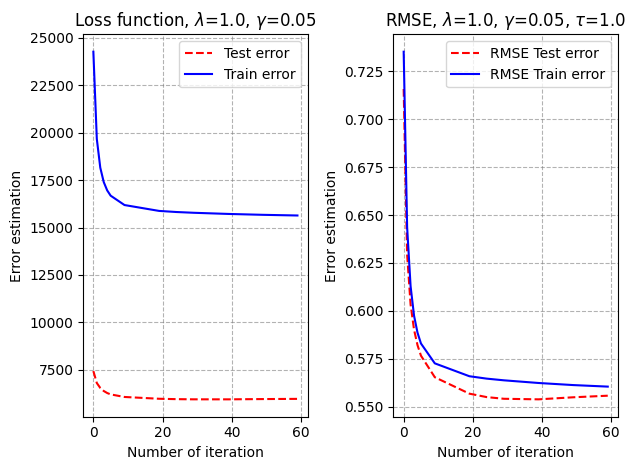

In [143]:
fig, ax = plt.subplots(1,2)
ax[0].plot(error_tracker, error_test, color="red", linestyle="dashed", label="Test error")
ax[0].plot(error_tracker, error_train, color="blue", linestyle="solid", label="Train error")
ax[0].set_xlabel("Number of iteration")
ax[0].set_ylabel("Error estimation")
ax[0].set_title(f"Loss function, $\lambda$={p_lambda}, $\gamma$={p_gamma}")
ax[0].legend(loc="upper right")
ax[0].grid(True, linestyle='--', color='gray', alpha=0.6)


ax[1].plot(error_tracker, rmse_test_list, color="red", linestyle="dashed", label="RMSE Test error")
ax[1].plot(error_tracker, rmse_train_list, color="blue", linestyle="solid", label="RMSE Train error")
ax[1].set_xlabel("Number of iteration")
ax[1].set_ylabel("Error estimation")
ax[1].set_title(f"RMSE, $\lambda$={p_lambda}, $\gamma$={p_gamma}, $\\tau$={user_tau}")
ax[1].legend(loc="upper right")
ax[1].grid(True, linestyle='--', color='gray', alpha=0.6)

plt.tight_layout()
# plt.suptitle(f"Error estimation for K={embedding_dim} $\lambda$ = {p_lambda} $\gamma$ = {p_gamma} $\tau$ = {user_tau}$", y=1.02)
plt.savefig(f"Error_{embedding_dim}_local_{p_lambda}_{p_gamma}_{user_tau}_func_no_feat.pdf")
plt.show()

In [10]:
rmse_test_list[:5]

[0.8866202053544378,
 0.828549732701429,
 0.8057042641547941,
 0.7958219856315407,
 0.790774770037698]

In [11]:
np.save("movie_embeddings.npy", me)
np.save("user_embeddings.npy", ue)
np.save("features_embedding.npy", ft)

In [12]:
import pandas as pd

movie_name_df = pd.read_csv(all_genres)

In [121]:
new_user = 1 / np.sqrt(embedding_dim) * np.random.randn(embedding_dim)

#Insert the movie index that the new user has rated
noted_movie_idx = movie_to_idx[292755]
rating = 5.0
tau = user_tau

In [122]:
def new_user_recommend(new_user, noted_movie_idx, rating,idx_to_movie=idx_to_movie, movie_name_df=movie_name_df, embed_movie=me, movie_biases=mb, p_lambda=p_lambda, p_gamma=p_gamma, tau=user_tau):
    loop = 20
    bias = 0.0
    movie = embed_movie[noted_movie_idx]
    outer = np.outer(movie, movie)
    invert_this = p_lambda * outer + tau * np.identity(movie.shape[0])
    movie_bias = movie_biases[noted_movie_idx]

    for i in range(loop):
        # Update the user's bias first
        bias = p_lambda * (rating - new_user @ movie - movie_bias)
        bias = bias / (p_lambda + p_gamma)

        # Update the trait vector afterward
        new_user = np.linalg.solve(invert_this, p_lambda * (rating - bias - movie_bias) * movie)

    print("Finished creating user profile")
    print("The movie that the user liked : ", 
      movie_name_df.loc[movie_name_df["movieId"] == idx_to_movie[noted_movie_idx], "title"])
    print("==" * 25,"*" * 5, "==" * 25)
    res = embed_movie @ new_user + bias + movie_biases
    # res = embed_movie @ new_user + movie_biases
    print(res.argsort())
    concat = np.hstack([np.array(range(res.shape[0])).reshape(-1,1).astype(np.int32), res.reshape(-1,1)])
    sorted_res = concat[concat[:, 1].argsort()[::-1]]
    ten_best = sorted_res[:10]
    res =  {
        int(index) : float(rating) for index, rating in ten_best
    }

    mv_idx = list(res.keys())
    real_indexes = []
    for mv in mv_idx:
        real_indexes.append(idx_to_movie[mv])

    names = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "title"]
    genres = movie_name_df.loc[movie_name_df["movieId"].isin(real_indexes), "genres"]

    print("Movie name \t||\t Movie genre")
    print("=" * 25)
    for name, genre in zip(names, genres):
        print(name, '\t\t', genre)

In [123]:
new_user_recommend(new_user, noted_movie_idx, rating)

Finished creating user profile
The movie that the user liked :  87583    The Angry Breed (1968)
Name: title, dtype: object
================================================== ***** ==================================================
[ 153 9806  163 ... 8015 8006 5319]
Movie name 	||	 Movie genre
Antonia's Line (Antonia) (1995) 		 Comedy|Drama
Beyond Silence (Jenseits der Stille) (1996) 		 Drama
Bandit Queen (1994) 		 Drama
Tango (1998) 		 Drama|Musical
Beau Pere (a.k.a. Stepfather) (Beau-père) (1981) 		 Drama
Way Home, The (Jibeuro) (2002) 		 Drama
Pellet (Bola, El) (2000) 		 Drama
Gloomy Sunday (Ein Lied von Liebe und Tod) (1999) 		 Drama|Romance
Heart Is Deceitful Above All Things, The (2004) 		 Drama
Tracey Fragments, The (2007) 		 Drama


In [120]:
movie_name_df[movie_name_df['genres'].str.contains('drama', case=False, na=False)]

,movieId,title,genres
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
10,11,"American President, The (1995)",Comedy|Drama|Romance
13,14,Nixon (1995),Drama
15,16,Casino (1995),Crime|Drama
16,17,Sense and Sensibility (1995),Drama|Romance
...,...,...,...
87579,292709,End of the Season (2017),Drama
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama


In [99]:
movie_name_df["title"][0]

'Toy Story (1995)'

### Only for K = 2 for plotting the features

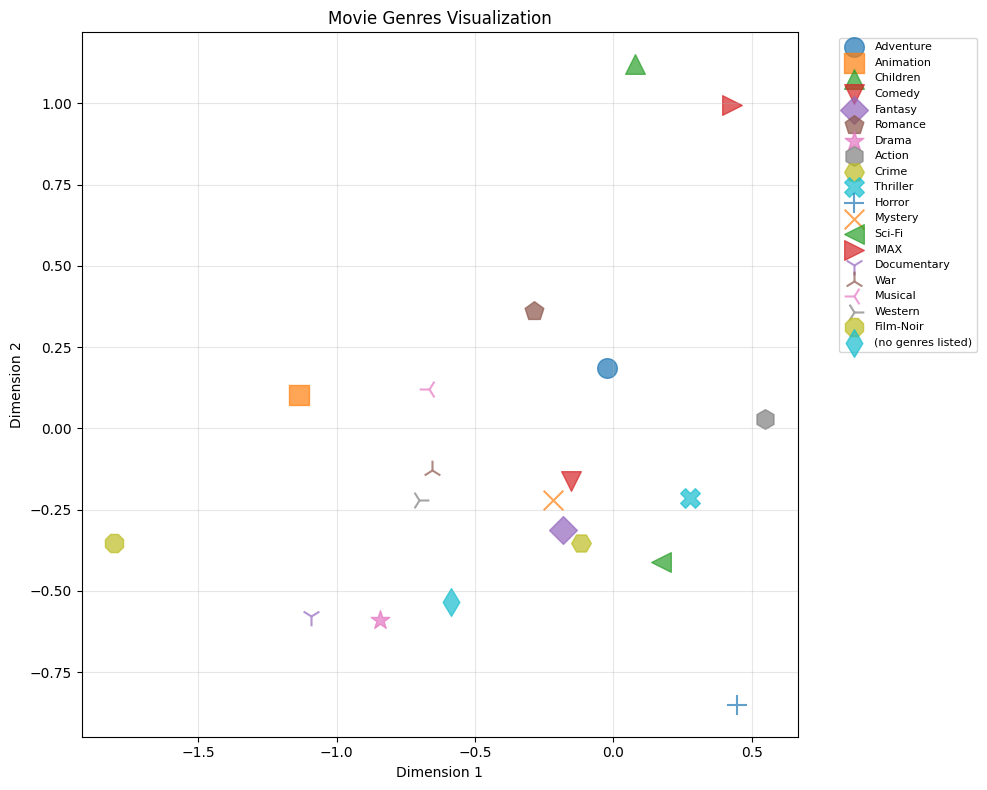

In [82]:
genres = list(genres_to_idx.keys())

# Define different markers
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', 'X',
           '+', 'x', '<', '>', '1', '2', '3', '4', '8', 'd']

# Create the plot
plt.figure(figsize=(10, 8))

# Plot each genre with a different marker
for i, genre in enumerate(genres):
    plt.scatter(ft[i, 0], ft[i, 1], 
                marker=markers[i], s=200, label=genre, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Movie Genres Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("movie_genres_visualization.pdf")
plt.show()